## Stacking Model Notebook 

### Here we try to Combine the Base Models with a Stacking Grid Search Model

In [35]:
# Pure Code for the Stacking Model with Pipelines

# Import Libraries

import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier

# import own modules
sys.path.append("..")  # Adds higher directory to python modules path.
from scripts import features as ft
from scripts import preprocessing as pp
from scripts import evaluate_models as em

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

import pickle

### Set some additional Parameters

In [36]:
# Additional Parameters
# metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# defaults
RSEED = 42
cv = 10
n_jobs = -1
verbose = 0

### Load the Dataframe

In [37]:
# path to csv file
path_df = os.path.join("..", "data", "df_deep_sam.csv")

# get features - or recalculate
recalculate_df = False
if os.path.isfile(path_df) and not recalculate_df:
    df = pd.read_csv(path_df)
else:
    df = ft.get_features()
    df.to_csv(path_df, index=False)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=['img', 'sp_idx'])
df = df.drop(columns=[col for col in df.columns if "_obj" in col])  # drop 'object' columns

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]

 -> dataframe has 7598 instances and 45 columns
 -> there are 45 numerical columns
 -> there are 0 categoricals columns


### Load the Baseline Models

In [38]:
# Load the RF model
with open("../models/RF_final/RF_final.pickle", "rb") as f:
    rf_model = pickle.load(f)


# Load the svc model
with open("../models/SVC_final/best_svc_resnet.pickle", "rb") as f:
    svc_model = pickle.load(f)

# Load the xgb model
with open("../models/xgb_final/xgb_final_new.pickle", "rb") as f:
    xgb_model = pickle.load(f)



# Do the Train Test Split 

In [39]:
# prepare features and target
X = df.drop("asd", axis=1)
y = df["asd"]

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6485' samples & '44' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


In [7]:
#use probability calibrator
calibrated_xgb = CalibratedClassifierCV(xgb_model, method='isotonic')
calibrated_rf = CalibratedClassifierCV(rf_model, method='isotonic')
calibrated_svc = CalibratedClassifierCV(svc_model, method='isotonic')

In [9]:
#fit calibrated models on training data (use respective feature subsets)
calibrated_xgb.fit(X_train, y_train)
calibrated_rf.fit(X_train, y_train)
calibrated_svc.fit(X_train, y_train)

CalibratedClassifierCV(estimator=Pipeline(steps=[('preprocessor',
                                                  ColumnTransformer(transformers=[('scaler',
                                                                                   StandardScaler(),
                                                                                   ['sp_fix_duration_ms_total',
                                                                                    'sp_fix_duration_ms_mean',
                                                                                    'sp_fix_duration_ms_var',
                                                                                    'sam_sal_first_fixation',
                                                                                    'sam_sal_sum',
                                                                                    'sam_sal_KLD',
                                                                                    'obj_t_abs_on_background',
                                                                                    'obj_t_abs_on_animate',
                                                                                    'obj_n_fix_background',
                                                                                    'obj_n_fix_inanimate',
                                                                                    'obj_n_fix_animate'])])),
                                                 ('classifier',
                                                  SVC(C=0.1, degree=4,
                                                      kernel='poly',
                                                      probability=True))]),
                       method='isotonic')

# Create Everything we need for the Master Model!
### Here we do everything for Training the Meta Model
For Predictions on the Test set the Code is a bit longer maybe we can Encapsulate everything in 1 Pipeline Later

### Predict on the Train Set with each Base Model Pipeline - 1 Class Pred and 1 Proba Pred

In [10]:
# 2. Generate predictions using the base models
svc_pred_train = calibrated_svc.predict(X_train)
xgb_pred_train = calibrated_xgb.predict(X_train)
rf_pred_train = calibrated_rf.predict(X_train)

# 2. Generate predictions using the base models
svc_proba_train = calibrated_svc.predict_proba(X_train)
xgb_proba_train = calibrated_xgb.predict_proba(X_train)
rf_proba_train = calibrated_rf.predict_proba(X_train)

## Do the Same on the Test Set!

In [11]:
# 2. Generate predictions using the base models
svc_pred_test = calibrated_svc.predict(X_test)
xgb_pred_test = calibrated_xgb.predict(X_test)
rf_pred_test = calibrated_rf.predict(X_test)

# 2. Generate predictions using the base models
svc_proba_test = calibrated_svc.predict_proba(X_test)
xgb_proba_test = calibrated_xgb.predict_proba(X_test)
rf_proba_test = calibrated_rf.predict_proba(X_test)

### Concatenate the predictions to from the Train & Test Set + Same for Proba Predictions

In [12]:
X_train_stacked = np.column_stack((svc_pred_train, xgb_pred_train, rf_pred_train))
X_test_stacked = np.column_stack((svc_pred_test, xgb_pred_test, rf_pred_test))

### Same for Probabilities

In [14]:
X_train_stacked_proba = np.column_stack((svc_proba_train, xgb_proba_train, rf_proba_train))
X_test_stacked_proba = np.column_stack((svc_proba_test, xgb_proba_test, rf_proba_test))

### Define the Master Modell and a Grid Search param_grid for it

In [17]:
# Define the master model (meta-learner)
master_model = LogisticRegression(max_iter=1000)

In [18]:

# Define a Param Grid for the Master Model
param_grid = {
    'master_model__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'master_model__penalty': ['l1', 'l2'],  # Regularization penalty
    'master_model__solver': ['liblinear', 'saga'],  # Solver for optimization problem
    'master_model__class_weight': [None, 'balanced'],  # Weights to balance class frequencies
    'master_model__dual': [False, True],  # Dual or primal formulation
    'master_model__fit_intercept': [True, False]  # Whether to calculate the intercept
}

### Make a Simple Pipeline for the Stacking Model to perform Grid Search with it

In [19]:
# Create a pipeline for grid search
stacking_pipeline = Pipeline([
    ('master_model', master_model)
])

### Grid Search for the Best Param we get out of the Log Reg Model 
You can ignore the failed fits, this is due to some parameters are not compatible in certain combinations in the Grid

In [20]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(stacking_pipeline, param_grid)
grid_search.fit(X_train_stacked_proba, y_train)

/Users/stefanschloegl/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
360 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/stefanschloegl/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/stefanschloegl/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^

GridSearchCV(estimator=Pipeline(steps=[('master_model',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'master_model__C': [0.001, 0.01, 0.1, 1.0, 10.0,
                                             100.0],
                         'master_model__class_weight': [None, 'balanced'],
                         'master_model__dual': [False, True],
                         'master_model__fit_intercept': [True, False],
                         'master_model__penalty': ['l1', 'l2'],
                         'master_model__solver': ['liblinear', 'saga']})

### Store the best Params and Score

In [21]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

### Print out best Parameters and Scores

In [22]:
best_params

{'master_model__C': 0.01,
 'master_model__class_weight': None,
 'master_model__dual': False,
 'master_model__fit_intercept': True,
 'master_model__penalty': 'l1',
 'master_model__solver': 'liblinear'}

In [23]:
best_score

0.7286044718581342

# Fit our Master Model with the best Hyperparameters

In [24]:
# Fit the meta-learner with the best parameters
best_master_model = LogisticRegression(C=0.01,class_weight=None,dual=False,fit_intercept=True,penalty="l1",solver="liblinear")
best_master_model.fit(X_train_stacked_proba, y_train)

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

### Let the Master Model Predict on Train and Test Set

In [25]:
# predict & proba
pred_test = best_master_model.predict(X_test_stacked_proba)
proba_test = best_master_model.predict_proba(X_test_stacked_proba)

pred_train = best_master_model.predict(X_train_stacked_proba)
proba_train = best_master_model.predict_proba(X_train_stacked_proba)

### Evaluate Model Performance

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.741     0.704     0.722      3252
           1      0.716     0.752     0.734      3233

    accuracy                          0.728      6485
   macro avg      0.729     0.728     0.728      6485
weighted avg      0.729     0.728     0.728      6485

f(0.5)-score: 0.723
f(2.0)-score: 0.745

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.702     0.722     0.712       371
           1      0.706     0.684     0.695       361

    accuracy                          0.704       732
   macro avg      0.704     0.703     0.703       732
weighted avg      0.704     0.704     0.703       732

f(0.5)-score: 0.701
f(2.0)-score: 0.688



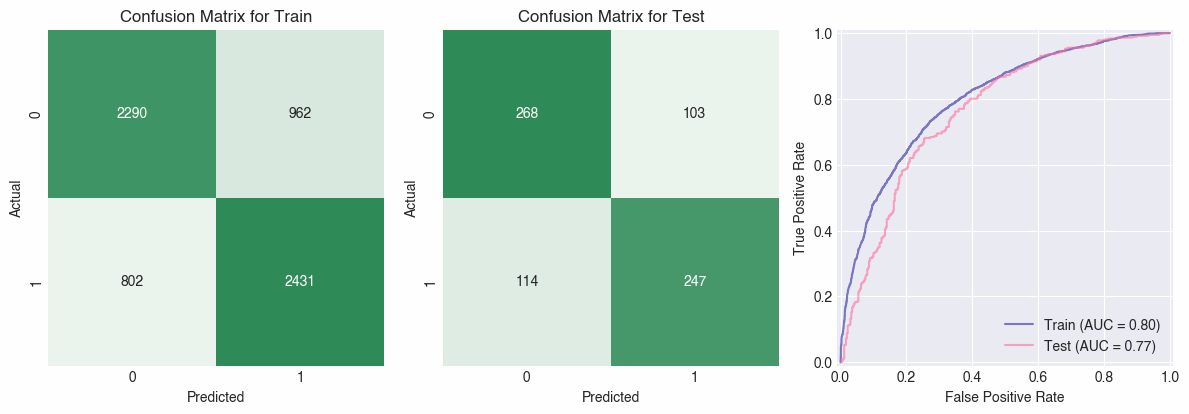

In [26]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

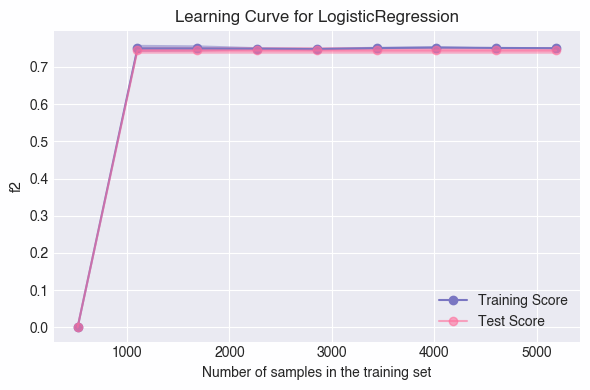

In [27]:
# learning curves - for one model - f2 score
em.learning(best_master_model, X_train_stacked, y_train)

# Store the best Model in a Pickle File

In [28]:
# Save the XGBoost model back to the same pickle file
pickle_file_path = "../models/Stacking_final/logreg_stacking_calibrated.pickle"
with open(pickle_file_path, "wb") as f:
    pickle.dump(best_master_model, f)